In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms

In [2]:
torch.cuda.empty_cache()
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
BATCH = 100
EPOCH = 5
LR = 0.001

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH, shuffle=False, num_workers=4, drop_last=False)

/home/doublez/anaconda3/envs/deep_learning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630841592/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print("Train dataset shape:", train_dataset.data.shape)
print("Test dataset shape:", test_dataset.data.shape)

# plt.imshow(train_dataset.data[0], cmap='gray')

Train dataset shape: torch.Size([60000, 28, 28])
Test dataset shape: torch.Size([10000, 28, 28])


In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(28*28, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),

            torch.nn.Linear(256, 10)
        )

        torch.nn.init.normal_(self.net[0].weight)
        torch.nn.init.normal_(self.net[-1].weight)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # size(0)是batch
        x = self.net(x)
        # return F.softmax(x)
        return x

In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.MaxPool2d(2)
        )
        self.linear = torch.nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        # return F.softmax(x)   # 最后如果加softmax loss会降不下去
        return x

In [8]:
model = CNN()
model.cuda()
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=LR)

In [9]:
loss_list = []
acc_list = []
for epoch in range(EPOCH):
    for step, (data, label) in enumerate(train_loader):
        model.train()

        predict = model(data.cuda())
        loss = loss_func(predict, label.cuda())

        optim.zero_grad()
        loss.backward()
        optim.step()

        if step % 100 == 0:
            model.eval()
            test_data = torch.unsqueeze(test_dataset.test_data, 1).type(torch.FloatTensor)
            test_predict = model(test_data.cuda())
            test_accuracy = sum(torch.argmax(test_predict, 1) == test_dataset.test_labels.cuda()) / len(test_dataset)
            print("Epoch {} | step {} | loss: {} | acc: {}".format(epoch, step, loss.data.cpu().numpy(), test_accuracy.cpu().numpy()))
            loss_list.append(loss.data.cpu().numpy())
            acc_list.append(test_accuracy.cpu().numpy())

/home/doublez/anaconda3/envs/deep_learning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/doublez/anaconda3/envs/deep_learning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Epoch 0 | step 0 | loss: 2.3012311458587646 | acc: 0.1492999941110611
Epoch 0 | step 100 | loss: 0.2700835168361664 | acc: 0.9004999995231628
Epoch 0 | step 200 | loss: 0.07357686758041382 | acc: 0.9455999732017517
Epoch 0 | step 300 | loss: 0.13594979047775269 | acc: 0.9679999947547913
Epoch 0 | step 400 | loss: 0.057857416570186615 | acc: 0.9713999629020691
Epoch 0 | step 500 | loss: 0.09343289583921432 | acc: 0.9758999943733215
Epoch 1 | step 0 | loss: 0.0410173274576664 | acc: 0.9765999913215637
Epoch 1 | step 100 | loss: 0.0751243382692337 | acc: 0.9708999991416931
Epoch 1 | step 200 | loss: 0.07934143394231796 | acc: 0.9747999906539917
Epoch 1 | step 300 | loss: 0.10485872626304626 | acc: 0.9789999723434448
Epoch 1 | step 400 | loss: 0.07561119645833969 | acc: 0.9788999557495117
Epoch 1 | step 500 | loss: 0.07611963897943497 | acc: 0.9795999526977539
Epoch 2 | step 0 | loss: 0.03365582600235939 | acc: 0.9788999557495117
Epoch 2 | step 100 | loss: 0.036087870597839355 | acc: 0.979

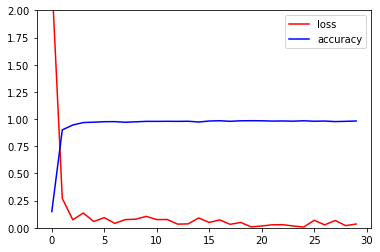

In [10]:
x = np.arange(len(loss_list))
plt.plot(x, loss_list, 'r', label='loss')
plt.plot(x, acc_list, 'b-', label='accuracy')
plt.ylim((0, 2))
plt.legend(loc='best')

predict: 7
real: 7


/home/doublez/anaconda3/envs/deep_learning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/doublez/anaconda3/envs/deep_learning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


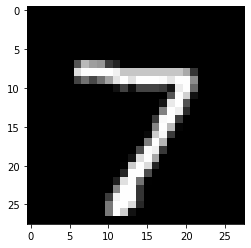

In [11]:
model.eval()
model.cpu()
test_x, test_y = test_dataset.test_data[0].type(torch.FloatTensor), test_dataset.test_labels[0]
plt.imshow(test_x, cmap='gray')
predict = model(test_x.unsqueeze(0).unsqueeze(0))
print("predict:", torch.argmax(predict).numpy())
print("real:", test_y.numpy())